# JEM092 Asset Pricing - Homework 1

<span style='background:yellow'> **Group : 20107894**</span>

Team Member:

Yanqi Guan : 20107894@fsv.cuni.cz

Lin Zhang : 15845542@fsv.cuni.cz

Jiayi Zeng : 46566215@fsv.cuni.cz


### Task 1 - Data download (8 pts)
In the previous step, you were assigned firms for which you will get the data. You will download 
* daily adjusted close price and volume data from www.finance.yahoo.com
* Market Capitalization and Book Value per Share data from www.macrotrends.net
* Sample period: 01.01.2007 - 28.02.2022 

In [13]:
# Setup environment
Sys.setenv(LANG = "en")
Sys.setlocale("LC_TIME", "English")
#options(warn = -1)  # suppressing warnings

if (!require(quantmod)) install.packages('quantmod')
if (!require(httr)) install.packages('httr')
if (!require(rvest)) install.packages('rvest')
if (!require(jsonlite)) install.packages('jsonlite')


library(quantmod)
library(httr)
library(rvest)
library(jsonlite)
library(PortfolioAnalytics)
#library(quadprog)
library(ROI)
#library(ROI.plugin.glpk)
#library(ROI.plugin.quadprog)


[1] "English_United States.1252"

**Task 2 - Markowitz portfolio (4 pts)**  
Using the data of the 20 stocks illustrate the portfolio performance by forming an efficient frontier. For the analysis, use either

20 random stocks from the data you have downloaded, i.e. stocks from "group_number_rand_download.csv" file
20 random stocks from the seminar, i.e. stocks from "group_number_rand_seminar.csv" file
choose this option in case you were not able to download data in Task 1
In this task, you will form 2 portfolios

portfolio A will consist of stocks 1 to 10
portfolio B will consist of stocks 11 to 20
Using the adjusted close price construct (and plot in the single figure) global minimum variance portfolio and the efficient frontier of both portfolio A and B. Since we will be working with monthly returns later in the course, use the monthly returns from the period 2015-2022 as the input for the task. Comment the important features of the figure, e.g. which portfolio will you choose? Why? Which stock(s) is driving the shape of the frontier? etc.

**(1). Reload data from Task 1**

In [2]:
load("1-price.RData")

In [3]:
symb <- attributes(OHLCV)$names
symb

[1] "ABT"  "CMS"  "PNR"  "AVB"  "IEX"  "SBAC" "QCOM" "BWA"  "WMB"  "DRI" 
[11] "WBA"  "VLO"  "CAT"  "NRG"  "MCK"  "STZ"  "ZBRA" "MHK"  "LRCX" "YUM"

**(2). Set Date Range**

In [14]:
# Function of set date range for xts
setRange <- function(xts_in, date_in){    
    return (xts_in[index(xts_in) > date_in])
}

# Call the function and output updated links
OHLCV_2015 <- lapply(OHLCV, setRange, as.Date("2015-01-01"))
head(OHLCV_2015[[1]])
tail(OHLCV_2015[[1]])

           ABT.Open ABT.High ABT.Low ABT.Close ABT.Volume ABT.Adjusted
2015-01-02    45.25    45.45   44.64     44.90    3216600     39.11632
2015-01-05    44.80    45.40   44.63     44.91    5735900     39.12504
2015-01-06    44.99    45.11   43.93     44.40    6584300     38.68072
2015-01-07    44.73    44.94   44.38     44.76    4609500     38.99435
2015-01-08    45.19    45.79   45.01     45.68    4883000     39.79584
2015-01-09    45.75    45.87   45.11     45.20    4742200     39.37768

           ABT.Open ABT.High ABT.Low ABT.Close ABT.Volume ABT.Adjusted
2022-02-17   122.99   123.18  120.47    120.58    3688300       120.58
2022-02-18   120.00   120.31  114.84    116.79   12376100       116.79
2022-02-22   116.54   119.33  116.10    117.51    8372800       117.51
2022-02-23   118.00   118.84  116.99    117.25    5184200       117.25
2022-02-24   115.00   118.92  114.43    118.72    6252600       118.72
2022-02-25   118.72   122.93  118.50    122.41    5837700       122.41

**(3). filter for adjusted close price.**

In [15]:
# only need the adjusted closing price for return

OHLCV_p <- lapply(names(OHLCV_2015), function(y){
    OHLCV_2015[[y]] <- OHLCV_2015[[y]][, paste0(y, '.Adjusted')]
})
names(OHLCV_p) <- names(OHLCV_2015)

# check columns
head(OHLCV_p[[1]])


           ABT.Adjusted
2015-01-02     39.11632
2015-01-05     39.12504
2015-01-06     38.68072
2015-01-07     38.99435
2015-01-08     39.79584
2015-01-09     39.37768

**(4). Set monthly data**


In [6]:
# Call to.period function
OHLCV_m <- lapply(OHLCV_p,to.period, period = 'months',name=NULL)

head(OHLCV_m[[1]])


               Open     High      Low    Close
2015-01-30 39.11632 39.79584 38.01843 39.20076
2015-02-27 39.61239 41.69679 38.99057 41.48660
2015-03-31 41.35523 41.88948 40.43564 40.57578
2015-04-30 40.19042 42.65836 40.19042 40.86259
2015-05-29 41.10026 43.43301 40.93300 42.78160
2015-06-30 43.08089 44.04040 42.31505 43.20414

**(5). calculate monthly return**
$$r_{i,t}=\frac{P_{i,t}-P_{i,t-1}}{P_{i,t-1}}$$

In [7]:
# Selected Close Price
OHLCV_c <- lapply(names(OHLCV_m), function(y){
    OHLCV_m[[y]] <- OHLCV_m[[y]][, 'Close']
})
names(OHLCV_c) <- names(OHLCV_m)

# compute simple returns
rets <- lapply(OHLCV_c, function(y){
  y <- na.omit(diff(y)/lag(y))
})

head(rets[[1]])


                  Close
2015-02-27  0.058310879
2015-03-31 -0.021954465
2015-04-30  0.007068453
2015-05-29  0.046962714
2015-06-30  0.009876464
2015-07-31  0.037791636

**(6). Create Portflio data**

In [8]:
# n_list is the whole 20 stocks portfolio
n_list <- do.call(merge, rets)
colnames(n_list) <- names(rets)

head(n_list)

                    ABT          CMS          PNR         AVB         IEX
2015-02-27  0.058310879 -0.061719871  0.075392752 -0.02688009  0.06786460
2015-03-31 -0.021954465 -0.006262268 -0.053859286  0.04251317 -0.01850881
2015-04-30  0.007068453 -0.028072305 -0.004084143 -0.05687229 -0.00667383
2015-05-29  0.046962714  0.014949332  0.030249307  0.01314363  0.02999607
2015-06-30  0.009876464 -0.067369710  0.073715802 -0.03233003  0.01708506
2015-07-31  0.037791636  0.076005059 -0.108595747  0.07800045 -0.02847639
                  SBAC        QCOM         BWA          WMB         DRI
2015-02-27  0.06863755  0.16090283  0.14033628  0.118102999  0.04268509
2015-03-31 -0.06102162 -0.03814672 -0.01594513  0.044307743  0.08343749
2015-04-30 -0.01093084 -0.01932483 -0.02116415  0.011859923 -0.07170884
2015-05-29 -0.03462270  0.02470579  0.01822501 -0.001758143  0.02775591
2015-06-30  0.02826243 -0.09494222 -0.05502928  0.137018620  0.08452844
2015-07-31  0.05001286  0.02810133 -0.12543974 -0.

**(7). Obtain Global Minimum Variance Portlio**

In [9]:
# Create the portfolio 1 as the first 10 stocks.
returns <- n_list[, 1:10]
funds <- colnames(returns)

# Create an initial portfolio object with leverage and box constraints.
initial_portfolio <- portfolio.spec(assets = funds)
initial_portfolio <- add.constraint(
    portfolio = initial_portfolio,
    type = "leverage",
    min_sum = 0.99,
    max_sum = 1.01
)

# Obtain optimized portfolio by optimize.portfolio function
minvar <- add.objective(portfolio = initial_portfolio, type = "risk", name = "var")
opt_minvar <- optimize.portfolio(
    R = returns,
    portfolio = minvar,
    optimize_method = "ROI",
    trace = TRUE
)

print(opt_minvar)

***********************************
PortfolioAnalytics Optimization
***********************************

Call:
optimize.portfolio(R = returns, portfolio = minvar, optimize_method = "ROI", 
    trace = TRUE)

Optimal Weights:
    ABT     CMS     PNR     AVB     IEX    SBAC    QCOM     BWA     WMB     DRI 
 0.1478  0.5610 -0.0325  0.0236  0.0482  0.0437  0.0256  0.0198  0.1243  0.0285 

Objective Measure:
 StdDev 
0.03524 





**(8). Analysis portfolio 1**


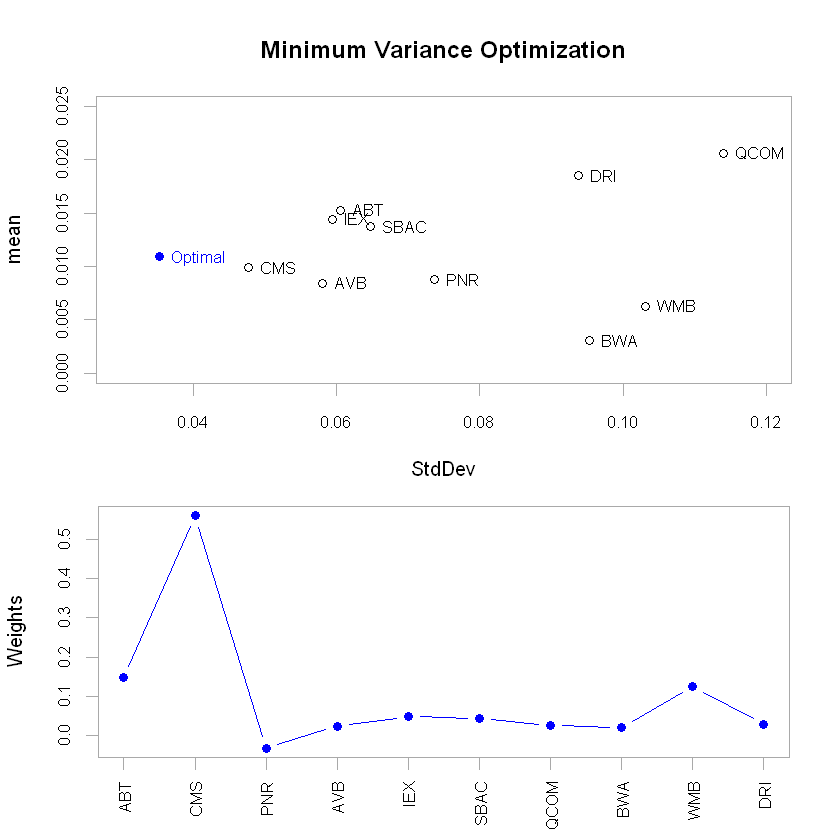

In [10]:
# Show each stock analsis in plot
plot(
    opt_minvar,
    risk.col = "StdDev",
    return.col = "mean",
    main = "Minimum Variance Optimization",
    chart.assets = TRUE,
    xlim = c(0.03, 0.12),
    ylim = c(0, 0.025)
)


**(9). Draw Efficient frontier**

Warning message in maxret_opt(R = R, constraints = constraints, moments = moments, :
"Inf or -Inf values detected in box constraints, maximum return 
            objectives must have finite box constraint values."
Warning message:
"executing %dopar% sequentially: no parallel backend registered"


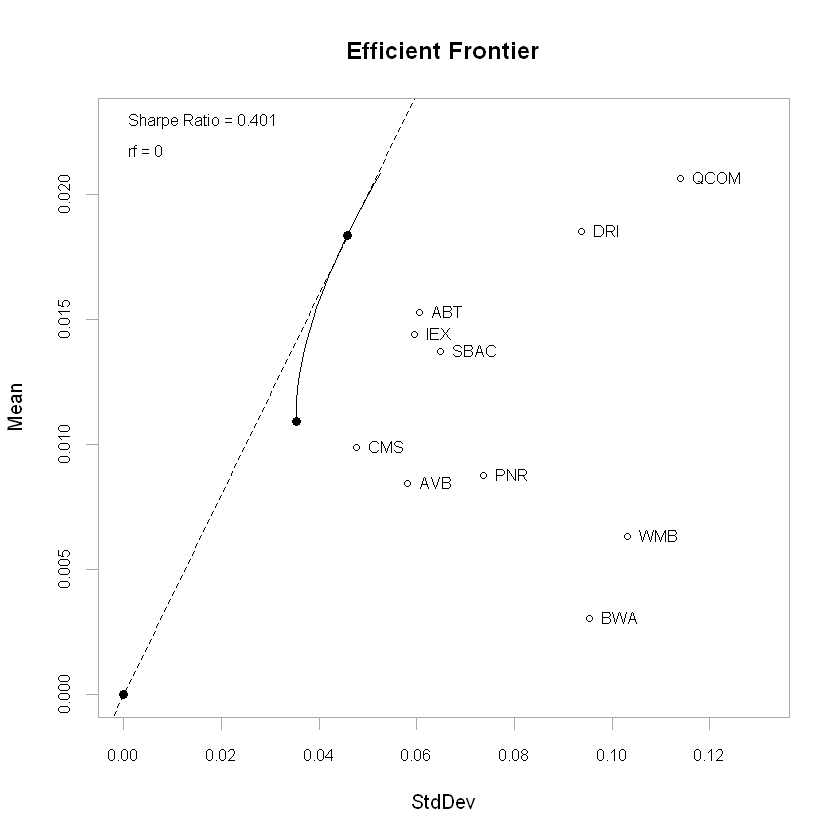

In [11]:
# Plot the efficient frontier.
meanvar <- create.EfficientFrontier(R = returns, portfolio = initial_portfolio, type = 'mean-var')
chart.EfficientFrontier(meanvar, match.col = 'StdDev', type = 'l', RAR.text = 'Sharpe Ratio', pch = 4)